In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from autograd.numpy.numpy_boxes import ArrayBox 
from collections.abc import Sized


import matplotlib.pyplot as plt
%matplotlib inline


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

Simple classifier with data reloading and fidelity loss
=======================================================


In [6]:
dev = qml.device("lightning.gpu", wires=2)

@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier with Compact encoding.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for l in range(params.shape[0]): # Iterate num_layers times
        w_0 = params[l, 0, :-1]
        b_0 = params[l, 0,  -1]
        w_1 = params[l, 1, :-1]
        b_1 = params[l, 1,  -1]
        
        encoding_0 = np.dot(w_1, x) + b_0
        
        encoding_1 = np.dot(w_1, x) + b_0
        
        qml.Rot(encoding_0, encoding_0, encoding_0, wires=0)
        qml.Rot(encoding_1, encoding_1, encoding_1, wires=1)

        
        qml.CZ([0, 1]) 
    
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized. Includes ArrayBox fix

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """


    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        if isinstance( y[i] , ArrayBox):
            label = dm_labels[int(y[i]._value)]
        else:
            label = dm_labels[y[i]]
        f = qcircuit(params, x[i], label)
        loss = loss + (1 - f) ** 2
        
        # if isinstance(f, Sized):
        #     print(f'Sized f recieved.\nf: {f}')
        
    return loss / len(x)

Utility functions for testing and creating batches
==================================================


In [7]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Train a quantum classifier on the circle dataset
================================================


In [8]:
# Generate training and test data
num_training = 500
num_test = 200

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))



In [9]:

num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 1*2, 3+1), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.476476 | Train accuracy: 0.500000 | Test Accuracy: 0.445000
Epoch:  1 | Loss: 0.343175 | Train accuracy: 0.486000 | Test accuracy: 0.445000
Epoch:  2 | Loss: 0.227549 | Train accuracy: 0.676000 | Test accuracy: 0.755000
Epoch:  3 | Loss: 0.188032 | Train accuracy: 0.734000 | Test accuracy: 0.775000
Epoch:  4 | Loss: 0.150577 | Train accuracy: 0.820000 | Test accuracy: 0.855000
Epoch:  5 | Loss: 0.133909 | Train accuracy: 0.850000 | Test accuracy: 0.880000
Epoch:  6 | Loss: 0.131958 | Train accuracy: 0.820000 | Test accuracy: 0.855000
Epoch:  7 | Loss: 0.131480 | Train accuracy: 0.814000 | Test accuracy: 0.865000
Epoch:  8 | Loss: 0.131106 | Train accuracy: 0.820000 | Test accuracy: 0.875000
Epoch:  9 | Loss: 0.130861 | Train accuracy: 0.820000 | Test accuracy: 0.870000
Epoch: 10 | Loss: 0.130502 | Train accuracy: 0.824000 | Test accuracy: 0.875000


Results
=======


Cost: 0.130502 | Train accuracy 0.824000 | Test Accuracy : 0.875000
Learned weights
Layer 0: [[0.15302004 0.25354556 0.55858234 2.41384284]
 [0.21182901 0.19749949 0.99227587 0.2839725 ]]
Layer 1: [[0.56959767 0.48662755 0.04654446 0.56023473]
 [0.04617159 0.95525097 0.48313465 0.28960131]]
Layer 2: [[ 0.40665984  0.61916185  0.91883631 -0.02991028]
 [ 2.17230884 -0.03812277  0.76669433  0.27562976]]


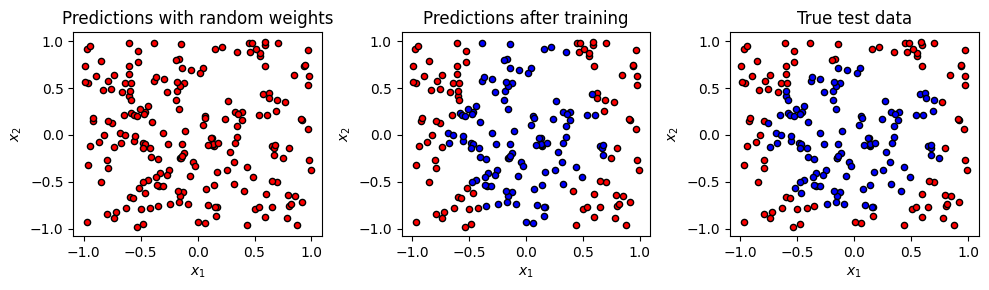

In [10]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

# Hypercubic Data

In [11]:
from sklearn.datasets import make_classification

n_samples = 500
n_features = 3
n_informative = 3
n_classes = 2

num_layers = 10
learning_rate = 0.6
epochs = 10
batch_size = 32

# Create a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=(n_features - n_informative),
    n_classes=n_classes,
    class_sep=10.,
    random_state=0
)

# set training and test data
split = int(0.8 * n_samples)
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:, :]
y_test = y[split:]

In [12]:

num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 12, n_features+1), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.328561 | Train accuracy: 0.572500 | Test Accuracy: 0.530000
Epoch:  1 | Loss: 0.312301 | Train accuracy: 0.502500 | Test accuracy: 0.560000
Epoch:  2 | Loss: 0.333230 | Train accuracy: 0.452500 | Test accuracy: 0.400000
Epoch:  3 | Loss: 0.317226 | Train accuracy: 0.505000 | Test accuracy: 0.410000
Epoch:  4 | Loss: 0.288814 | Train accuracy: 0.542500 | Test accuracy: 0.520000
Epoch:  5 | Loss: 0.311785 | Train accuracy: 0.472500 | Test accuracy: 0.440000


# High-dimensional Annulus

In [13]:
import pandas as pd
import plotly.express as px
import numpy as np


def annulus(samples, dimensions, inner_radius=1.0, outer_radius=2.0):
    """
    Generates an n-dimensional dataset of points with 1/0 labels inside an annulus.

    Args:
        samples (int): number of samples to generate
        dimensions (int): number of dimensions for the dataset
        center (array): center of the annulus
        inner_radius (float): inner radius of the annulus
        outer_radius (float): outer radius of the annulus

    Returns:
        Xvals (array): coordinates of points
        yvals (array): classification labels
    """
    Xvals, yvals = [], []
    center = np.zeros(dimensions)
    
    for i in range(samples):
        x = 2 * (np.random.rand(dimensions)) - 1
        y = 0
        distance_to_center = np.linalg.norm(x - center)
        
        if inner_radius < distance_to_center < outer_radius:
            y = 1
        
        Xvals.append(x)
        yvals.append(y)

    return np.array(Xvals), np.array(yvals)


samples = 1000
dimensions = 6
X_train, y_train = annulus(samples, dimensions, inner_radius=0.0, outer_radius=0.8)
X_test, y_test = annulus(samples, dimensions, inner_radius=0.0, outer_radius=0.8)

# df = pd.DataFrame(X_train[:, :3], columns=[f'Dimension {i+1}' for i in range(3)])
# df['Label'] = y_train

# # Create an interactive 3D scatter plot
# fig = px.scatter_3d(df, x='Dimension 1', y='Dimension 2', z='Dimension 3', color='Label',
#                     symbol='Label', opacity=0.5, title='3D Annulus Dataset')

# # Show the plot
# fig.show()

In [17]:
from pennylane import numpy as np

num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32



opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2, dimensions+1), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)
# print('loss: ', loss)
# print('accuracy_train: ', accuracy_train)
# print('accuracy_test: ', accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]

    print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        it+1, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.089228 | Train accuracy: 0.915000 | Test Accuracy: 0.931000
Epoch:  1 | Cost: 0.053787 | Train accuracy: 0.973000 | Test Accuracy: 0.984000
Epoch:  2 | Cost: 0.045451 | Train accuracy: 0.974000 | Test Accuracy: 0.985000


KeyboardInterrupt: 

# Hypercubic Clusters 

In [18]:
from pennylane import numpy as np

n_samples = 500
n_features = 6
n_informative = 4
n_classes = 2

num_layers = 10
learning_rate = 0.6
epochs = 10
batch_size = 32

    
    # n_samples = 500
    # n_features = 6
    # n_informative = 2
    # n_redundant = 4
    # n_classes = 2

# Create a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=(n_features - n_informative),
    n_classes=n_classes,
    class_sep=2.,
    random_state=0
)

# X = np.array(X)
# y = np.array(y)

# set training and test data
split = int(0.8 * n_samples)
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:, :]
y_test = y[split:]


num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 1*2, n_features+1))
params = np.array(params, requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.318154 | Train accuracy: 0.600000 | Test Accuracy: 0.560000
Epoch:  1 | Loss: 0.264493 | Train accuracy: 0.572500 | Test accuracy: 0.500000
Epoch:  2 | Loss: 0.286653 | Train accuracy: 0.517500 | Test accuracy: 0.510000
Epoch:  3 | Loss: 0.299432 | Train accuracy: 0.515000 | Test accuracy: 0.550000
Epoch:  4 | Loss: 0.304797 | Train accuracy: 0.522500 | Test accuracy: 0.430000
Epoch:  5 | Loss: 0.335741 | Train accuracy: 0.450000 | Test accuracy: 0.320000
